<a href="https://colab.research.google.com/github/ttya16/kaggle_LANL_Earthquake_Prediction/blob/master/kaggle_LANL_earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LANL-Earthquake-Prediction  
Referenced some ideas for feature engineering and dataset overview from [Kaggle kernels](https://www.kaggle.com/c/LANL-Earthquake-Prediction/kernels)


##方針・概要
地震波データを150000ごとに区切って特徴量をいくつか計算し、
その時点での次の地震発生までの時間(TTF、time to failure)を予測する。GradientBoosting、XGBoost、RNN(GRU)のモデルで学習させてそれぞれの結果を比較した。
![image](https://raw.githubusercontent.com/ttya16/kaggle_LANL_Earthquake_Prediction/master/earthquake_ttf_prediction.png?token=AtZ-H-5TXpS8lXsMD1IdKUtVT6aFqrHCks5ckszJwA%3D%3D)

##データセットの準備
Colabにデータセットをダウンロードするフェーズ<br>
ローカルでやる場合は不要

In [1]:
#kaggleコンペのデータをダウンロードするための準備
!pip install kaggle
!pip install numpy==1.16.0 #numpy.quantileを使いたいため

In [2]:
#import data files from kaggle
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2560           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10335            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4062           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2564           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [4]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 10.8MB/s]
100% 242M/242M [00:02<00:00, 115MB/s]

100% 2.02G/2.03G [00:18<00:00, 114MB/s]
100% 2.03G/2.03G [00:18<00:00, 116MB/s]


In [5]:
#Dowloadした訓練用ファイルを展開
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


##EDA
[これ](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)
とか参照

In [0]:
import numpy as np
import pandas as pd

In [0]:
%%time
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
train['cumsum'] = train['acoustic_data'].abs().cumsum()
train.to_csv('train_mod.csv')

In [0]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

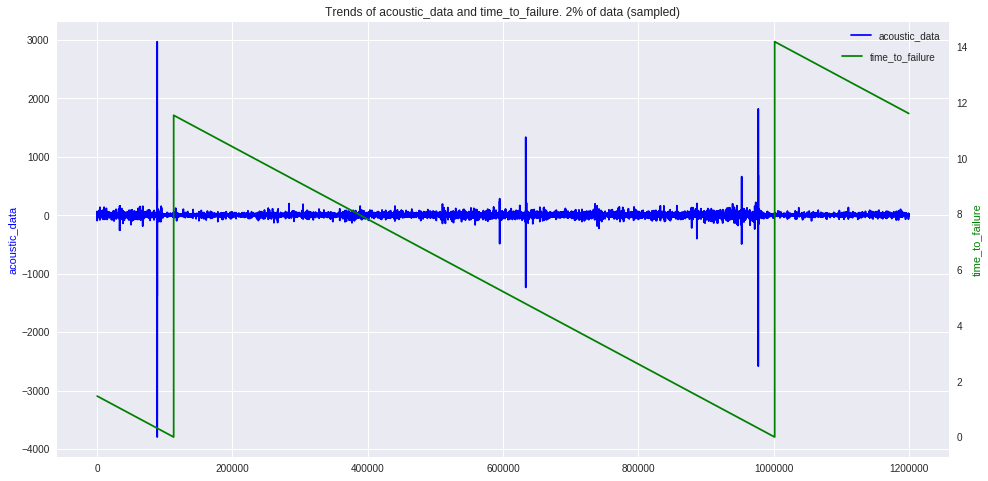

In [0]:
#visualize data
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

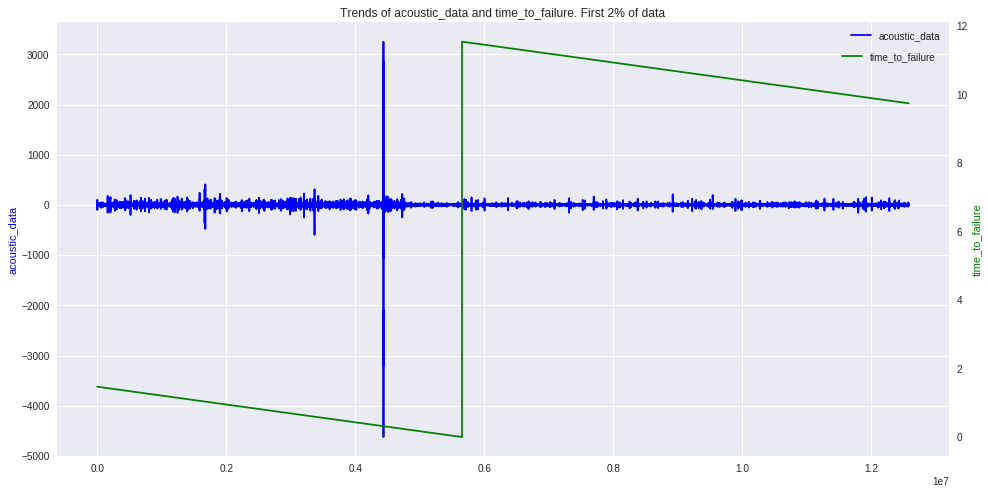

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

##Feature Engineering

In [0]:
#Add some statistical features to the dataset
#特徴量サンプリングとして基本的な統計量をいくつか追加してみる
#平均、標準偏差、最小値、最大値、尖度(kurtosis)、歪度(skewness)、差分 etc.

#190321 セグメントごとの端何件か（edge_rows）の平均、std、差分を特徴量として追加
#190321 minとskewはなんとなく要らなそうなので除いてみた（feature_importanceで要検証）
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    #strain.append(X.min())
    strain.append(X.max())
    strain.append(X.median())
    strain.append(X.kurtosis())
    #strain.append(X.skew())
    strain.append(np.quantile(X, 0.01))
    strain.append(np.quantile(X, 0.05))
    strain.append(np.quantile(X, 0.95))
    strain.append(np.quantile(X, 0.99))
    strain.append(np.mean(np.diff(X)))
    
    strain.append(np.mean(np.abs(X)))
    strain.append(X.max() - X.min())
    
    #modified 19.03.21
    for edge_rows in [25000, 50000]:
      strain.append(X[:edge_rows].mean())
      strain.append(X[:edge_rows].std())
      strain.append(X[:edge_rows].max())
      strain.append(np.mean(np.diff(X[:edge_rows])))
      strain.append(np.std(np.diff(X[:edge_rows])))
      strain.append(np.mean(np.cumsum(np.abs(X[:edge_rows]))))
      strain.append(np.std(np.cumsum(np.abs(X[:edge_rows]))))
      strain.append(X[-edge_rows:].mean())
      strain.append(X[-edge_rows:].std())
      strain.append(X[-edge_rows:].max())
      strain.append(np.mean(np.diff(X[-edge_rows:])))
      strain.append(np.std(np.diff(X[-edge_rows:])))
      strain.append(np.mean(np.cumsum(np.abs(X[-edge_rows:]))))
      strain.append(np.std(np.cumsum(np.abs(X[-edge_rows:]))))
      
    
    #rolling data of window size 100
    #X_roll_std = X.rolling(100).std().dropna().values
    #X_roll_mean = X.rolling(100).mean().dropna().values
    
    #strain.append(X_roll_std.mean())
    #strain.append(X_roll_std.std())
    #strain.append(X_roll_std.min())
    #strain.append(X_roll_std.max())
    #strain.append(np.mean(np.diff(X_roll_std)))
    #strain.append(np.mean(np.abs(X_roll_std)))
    #strain.append(X_roll_mean.mean())
    #strain.append(X_roll_mean.std())
    #strain.append(X_roll_mean.min())
    #strain.append(X_roll_mean.max())
    #strain.append(np.mean(np.diff(X_roll_mean)))
    #strain.append(np.mean(np.abs(X_roll_mean)))

    
    return pd.Series(strain)


### 学習データ準備
メモリ対策でchunksize指定で読み込んでいく。
特徴量の計算はテストデータのサイズに合わせて150000ごとに計算する。

In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv", iterator=True, chunksize=150000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()

for chunk in train:
  df = df.append(chunk)
  if len(df) >= 150000:
    df = df[-150000:]
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    

In [3]:
#標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
print(X_train_sc.shape)
X_train_sc[0]

(4195, 40)


array([ 1.4243304 , -0.17014507, -0.2181291 ,  0.94727584, -0.49115666,
        0.22863044,  0.07886163, -0.09827707, -0.16325772, -1.32660275,
        0.01925324, -0.20797671,  1.78808637,  0.3033706 ,  0.29603287,
       -1.25448764,  0.21059223,  0.77874462,  0.2474456 , -0.04785077,
       -0.21767513, -0.34960592, -0.3432133 , -0.16268136, -0.17966099,
       -0.17585364,  1.60202869,  0.05215375,  0.01201008, -0.6737523 ,
        0.00246902,  0.47934647,  0.07551351,  0.36725035, -0.28552915,
       -0.40013485, -0.21040771, -0.21089604, -0.2711468 , -0.20657263])

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_sc, y_train, test_size=0.1,shuffle=False)

In [5]:
print(X_tr.shape)
print(X_val.shape)

(3775, 40)
(420, 40)


In [6]:
y_train.shape

(4195,)

## Create Model & Train

### GradientBoosting

In [0]:
#勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gbrt = GradientBoostingRegressor(max_depth = 2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 300):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_tr, y_tr)
  y_pred = gbrt.predict(X_val)
  val_error = mean_absolute_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    
  if error_going_up > 10:
    break


In [7]:
#早期打ち切りなしでやりたい場合
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=200)
gbrt.fit(X_tr, y_tr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### XGBoost

In [8]:
#XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=3, n_estimators = 200)

xgb_model.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### RNN

In [17]:
#RNN model
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNGRU, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
n_features = X_tr.shape[1]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_2 (CuDNNGRU)       (None, 48)                12960     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                490       
_________________________________________________________________
batch_normalization_3 (Batch (None, 10)                40        
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 13,501
Trainable params: 13,481
Non-trainable params: 20
_________________________________________________________________


In [21]:
#Bidirectional GRU (modified 190321)
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNGRU, Dropout, BatchNormalization, Bidirectional

model_bi = Sequential()
model_bi.add(Bidirectional(CuDNNGRU(48), input_shape=(None, n_features)))
model_bi.add(Dense(10, activation='elu'))
model_bi.add(BatchNormalization())
model_bi.add(Dropout(0.2))
model_bi.add(Dense(1))

model_bi.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 96)                25920     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                970       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10)                40        
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 26,941
Trainable params: 26,921
Non-trainable params: 20
_________________________________________________________________


In [0]:
X_tr_reshaped = np.reshape(np.array(X_tr), (X_tr.shape[0], 1, X_tr.shape[1]))

In [19]:
#compile & train RNN model
from keras.optimizers import adam
model.compile(optimizer = adam(lr=0.005), loss='MAE')
model.fit(X_tr_reshaped, y_tr, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
3775/3775 [==============================] - 2s 635us/step - loss: 4.0653
Epoch 2/20
3775/3775 [==============================] - 1s 313us/step - loss: 2.4647
Epoch 3/20
3775/3775 [==============================] - 1s 326us/step - loss: 2.3781
Epoch 4/20
3775/3775 [==============================] - 1s 329us/step - loss: 2.3504
Epoch 5/20
3775/3775 [==============================] - 1s 330us/step - loss: 2.2914
Epoch 6/20
3775/3775 [==============================] - 1s 328us/step - loss: 2.2797
Epoch 7/20
3775/3775 [==============================] - 1s 333us/step - loss: 2.2788
Epoch 8/20
3775/3775 [==============================] - 1s 330us/step - loss: 2.2669
Epoch 9/20
3775/3775 [==============================] - 1s 314us/step - loss: 2.2723
Epoch 10/20
3775/3775 [==============================] - 1s 313us/step - loss: 2.2531
Epoch 11/20
3775/3775 [==============================] - 1s 337us/step - loss: 2.2509
Epoch 12/20
3775/3775 [==============================] - 1s 337

In [22]:
#compile & train bidirectional RNN model
from keras.optimizers import adam
model_bi.compile(optimizer = adam(lr=0.005), loss='MAE')
model_bi.fit(X_tr_reshaped, y_tr, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
3775/3775 [==============================] - 3s 853us/step - loss: 4.0245
Epoch 2/20
3775/3775 [==============================] - 2s 407us/step - loss: 2.4592
Epoch 3/20
3775/3775 [==============================] - 1s 356us/step - loss: 2.3694
Epoch 4/20
3775/3775 [==============================] - 2s 417us/step - loss: 2.3665
Epoch 5/20
3775/3775 [==============================] - 2s 415us/step - loss: 2.3246
Epoch 6/20
3775/3775 [==============================] - 2s 403us/step - loss: 2.3367
Epoch 7/20
3775/3775 [==============================] - 2s 425us/step - loss: 2.2818
Epoch 8/20
3775/3775 [==============================] - 2s 435us/step - loss: 2.2718
Epoch 9/20
3775/3775 [==============================] - 2s 413us/step - loss: 2.2841
Epoch 10/20
3775/3775 [==============================] - 2s 398us/step - loss: 2.2535
Epoch 11/20
3775/3775 [==============================] - 2s 413us/step - loss: 2.2193
Epoch 12/20
3775/3775 [==============================] - 1s 392

### Plot results

GRU 1.7671999271905883
Bidirectional GRU 1.6665377880021919
GradientBoosting 2.391368233591136
XGBoosting 2.4581209475221457
Blend 1.6017824234896831


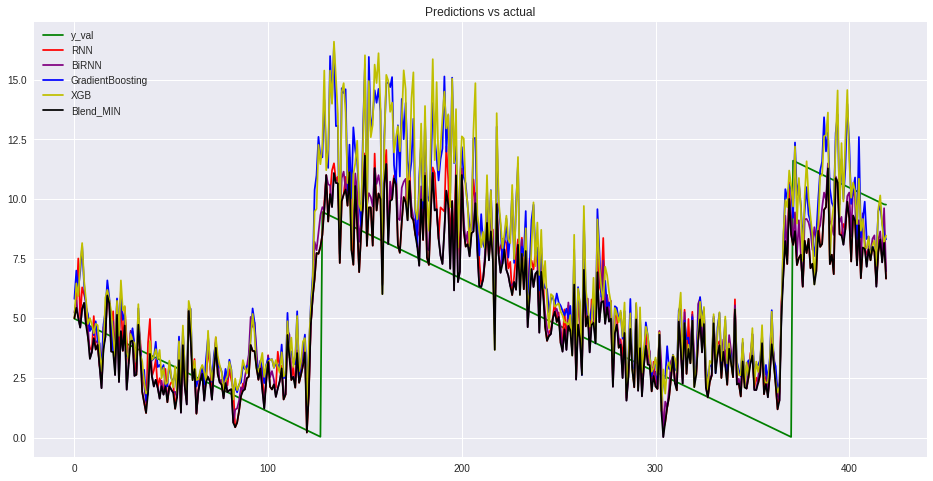

In [40]:
X_val_reshaped = np.reshape(np.array(X_val), (X_val.shape[0], 1, X_val.shape[1]))

y_pred_rnn = model.predict(X_val_reshaped)
y_pred_birnn = model_bi.predict(X_val_reshaped)
y_pred_gbrt = gbrt.predict(X_val)
y_pred_xgb = xgb_model.predict(X_val)
y_pred_blend_min = np.stack([np.reshape(y_pred_rnn, (y_pred_rnn.shape[0],)), np.reshape(y_pred_birnn, (y_pred_birnn.shape[0],)),  y_pred_gbrt, y_pred_xgb], axis=1).min(axis=1)

val_error_rnn = mean_absolute_error(y_val, y_pred_rnn)
val_error_birnn = mean_absolute_error(y_val, y_pred_birnn)
val_error_gbrt = mean_absolute_error(y_val, y_pred_gbrt)
val_error_xgb = mean_absolute_error(y_val, y_pred_xgb)
val_error_blend_min = mean_absolute_error(y_val, y_pred_blend_min)

print("GRU", val_error_rnn)
print("Bidirectional GRU", val_error_birnn)
print("GradientBoosting",val_error_gbrt)
print("XGBoosting", val_error_xgb)
print("Blend", val_error_blend_min)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(np.array(y_val), color='g', label='y_val')
plt.plot(y_pred_rnn, color='r', label='RNN')
plt.plot(y_pred_birnn, color='purple', label='BiRNN')
plt.plot(y_pred_gbrt, color='b', label='GradientBoosting')
plt.plot(y_pred_xgb, color='y', label='XGB')
plt.plot(y_pred_blend_min, color='k', label='Blend_MIN')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### 考察

・全体的に予測値は真の値よりも大きい傾向がある？<br>→各モデルの予測値のうち最小のものを選択した結果Blend_MIXの誤差が最小になった。<br>
・Validation Scoreはどのモデルも似たり寄ったりでそんなに良くないが、特徴量次第では変わってくるかもしれない。

## テストデータをfitさせる

In [0]:
#テストデータを展開
!unzip test.zip

In [25]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test = sc.fit_transform(X_test)
print(X_test.shape)

(2624, 40)


In [0]:
X_test_reshaped = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))

pred_rnn = model.predict(X_test_reshaped)
pred_birnn = model_bi.predict(X_test_reshaped)
pred_gbrt = gbrt.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_blend_mean = np.stack([np.reshape(pred_rnn, (pred_rnn.shape[0],)), np.reshape(pred_birnn, (pred_birnn.shape[0],)),  pred_gbrt, pred_xgb], axis=1).mean(axis=1)

In [0]:
submission['time_to_failure'] = pred_rnn
submission.to_csv('submission_gru.csv')

In [31]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "190322_bidirectional rnn"

100% 74.8k/74.8k [00:01<00:00, 41.9kB/s]
Successfully submitted to LANL Earthquake Prediction

↑Blend_MINの結果を提出してスコア1.744だった。
テストデータに偶然良くハマった可能性がある。

(190322)特徴量を色々追加してBidirectionalRNNのモデルでも検証
<br>validation scoreは改善したものの、submit scoreは良くならない。

## Further Improvements
* 特徴量の改善？
* 学習データの整形ももっといい方法があるか？
* 別のモデル？(CatBoost, BiDirectionalRNN)